## Imports

In [1]:
# !pip install snntorch
# !pip install matplotlib
# !pip install nir
# !pip install torchviz
# !pip install graphviz
# !pip install torchview

In [1]:
import torch
import snntorch as snn
import snntorch.functional as SF
from snntorch import RSynaptic
from snntorch import spikeplot as splt
import matplotlib.pyplot as plt
import nir
import torch
import torch.nn as nn
from torchviz import make_dot
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchview import draw_graph

In [2]:
from model import SpikingNet
from train import Trainer
from options import Options
from graph import Graph
from mapping import Mapping

## Define model with modified RSynaptic

In [3]:
opt = Options()
# Initialize the network
net = SpikingNet(opt)

HI


In [4]:
torch.manual_seed(42)
sample_data = torch.randn(opt.num_steps, opt.num_inputs)

indices_to_lock = {
    "indices" : ((0, 1), (90, 50)),
    "layers"  : ("lif1","lif1")}

try:
    prediction, _ = net(sample_data, indices_to_lock["indices"])
except:
    prediction, _ = net(sample_data, indices_to_lock["indices"])

print("Updated weights:\n", net.lif1.recurrent.weight.data)

Updated weights:
 tensor([[ 0.0912,  0.0000, -0.0509,  ...,  0.0363,  0.0762, -0.0116],
        [ 0.0578, -0.0704,  0.0776,  ..., -0.0946,  0.0272, -0.0224],
        [ 0.0949, -0.0541,  0.0359,  ...,  0.0295, -0.0977,  0.0786],
        ...,
        [ 0.0792,  0.0518, -0.0414,  ..., -0.0729,  0.0705,  0.0432],
        [-0.0585,  0.0874, -0.0500,  ..., -0.0573, -0.0526,  0.0508],
        [ 0.0522,  0.0705,  0.0037,  ..., -0.0694,  0.0675, -0.0171]])


## NIR Graph

Extracted edges: [('lif1.w_rec', 'lif1.lif'), ('input', 'fc1'), ('fc2', 'lif2'), ('lif1.lif', 'lif1.w_rec'), ('lif2', 'output'), ('fc1', 'lif1.lif'), ('lif1.lif', 'fc2')]
Recurrent edges: [('lif1.w_rec', 'lif1.lif')]
Nodes: ['input', 'lif2', 'output', 'lif1']
Edges: [('input', 'lif1'), ('lif2', 'output'), ('lif1', 'lif2'), ('lif1', 'lif1')]


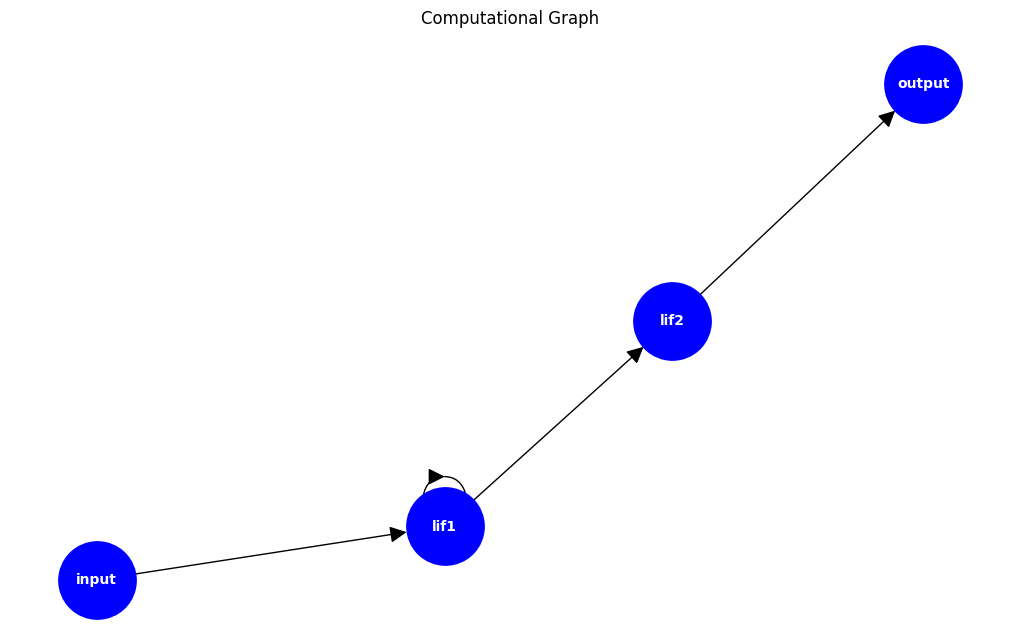

In [5]:
gp = Graph(opt.num_steps, opt.num_inputs)
gp.export_model(net)
gp.extract_edges()
gp.process_graph()
gp.plot_graph()

## Mapping

In [7]:
mapping = Mapping(net, opt.num_steps, opt.num_inputs, opt.core_capacity, indices_to_lock)
#mem_potential_sizes = mapping.get_membrane_potential_sizes()
for layer_name, size in mapping.mem_potential_sizes.items():
    print(f"Layer: {layer_name}, Number of neurons: {size}")

for layer_name, allocations in mapping.core_allocation.items():
    print(f"Layer: {layer_name}")
    for core_id, start_idx, end_idx in allocations:
        print(f"  Core {core_id}: start index = {start_idx}, end index = {end_idx}")

print(mapping.core_allocation)
print(mapping.NIR_to_cores)
print(mapping.neuron_to_core)
print(mapping.buffer_map)

Layer: lif1, Number of neurons: 100
Layer: lif2, Number of neurons: 2
Layer: lif1
  Core 0: start index = 0, end index = 49
  Core 1: start index = 50, end index = 99
Layer: lif2
  Core 3: start index = 0, end index = 1
{'lif1': [(0, 0, 49), (1, 50, 99)], 'lif2': [(3, 0, 1)]}
{'lif1': [(0, 49), (1, 49)], 'lif2': [(3, 1)]}
{'lif1-0': 0, 'lif1-1': 0, 'lif1-2': 0, 'lif1-3': 0, 'lif1-4': 0, 'lif1-5': 0, 'lif1-6': 0, 'lif1-7': 0, 'lif1-8': 0, 'lif1-9': 0, 'lif1-10': 0, 'lif1-11': 0, 'lif1-12': 0, 'lif1-13': 0, 'lif1-14': 0, 'lif1-15': 0, 'lif1-16': 0, 'lif1-17': 0, 'lif1-18': 0, 'lif1-19': 0, 'lif1-20': 0, 'lif1-21': 0, 'lif1-22': 0, 'lif1-23': 0, 'lif1-24': 0, 'lif1-25': 0, 'lif1-26': 0, 'lif1-27': 0, 'lif1-28': 0, 'lif1-29': 0, 'lif1-30': 0, 'lif1-31': 0, 'lif1-32': 0, 'lif1-33': 0, 'lif1-34': 0, 'lif1-35': 0, 'lif1-36': 0, 'lif1-37': 0, 'lif1-38': 0, 'lif1-39': 0, 'lif1-40': 0, 'lif1-41': 0, 'lif1-42': 0, 'lif1-43': 0, 'lif1-44': 0, 'lif1-45': 0, 'lif1-46': 0, 'lif1-47': 0, 'lif1-48': 0,

## Train model

In [8]:
trainer = Trainer(net, num_epochs=150, learning_rate=1e-4, target_frequency=0.5, batch_size=16, num_steps=100)
net = trainer.train(opt.device)

Epoch [10/150], Loss: 58.7762
Epoch [20/150], Loss: 57.7400
Epoch [30/150], Loss: 56.6413
Epoch [40/150], Loss: 54.7000
Epoch [50/150], Loss: 54.5675
Epoch [60/150], Loss: 54.7825
Epoch [70/150], Loss: 51.2225
Epoch [80/150], Loss: 48.8175
Epoch [90/150], Loss: 47.1875
Epoch [100/150], Loss: 45.4912
Epoch [110/150], Loss: 44.3350
Epoch [120/150], Loss: 38.6963
Epoch [130/150], Loss: 36.6838
Epoch [140/150], Loss: 33.7975
Epoch [150/150], Loss: 31.8375


## Record Spikes

In [10]:
# Dictionary to store spikes from each layer

spike_record = {}
hooks = []

def reset_spike_record_and_hooks():
  global spike_record, hooks

  # Clear the spike_record dictionary
  spike_record = {}

  # Remove existing hooks if they are already registered
  if 'hooks' in globals():
    for hook in hooks:
      hook.remove()
      hooks = []

# Function to create a hook that records spikes
def create_spike_hook(layer_name):
  def hook(module, input, output):
    if layer_name not in spike_record:
      spike_record[layer_name] = []
    spike_record[layer_name].append(output[0].detach().cpu())
  return hook

reset_spike_record_and_hooks()

# Attach hooks automatically to all Leaky layers
for name, module in net.named_modules():
  if isinstance(module, snn.Leaky) or isinstance(module, snn.RSynaptic):
    hooks.append(module.register_forward_hook(create_spike_hook(name)))

### Record spike trains

torch.Size([100, 100])
torch.Size([100, 1, 2])


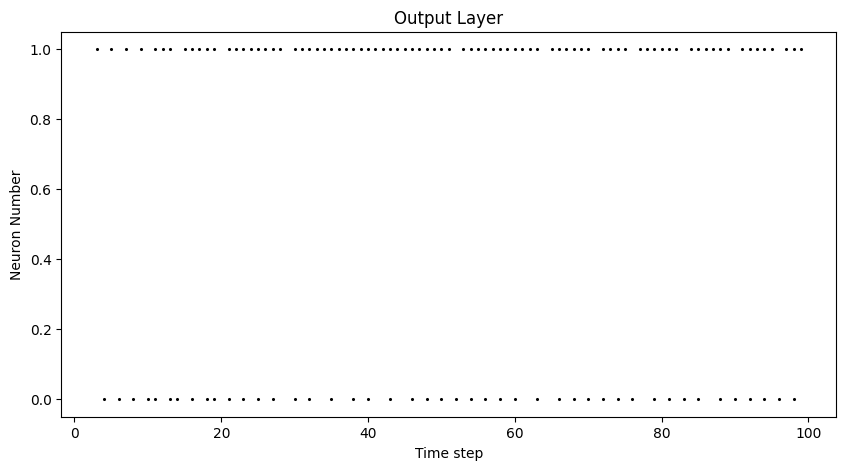

In [12]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt

# Dictionary to store spikes from each layer

spike_record = {}
hooks = []

# Generate random input data
indices = [1]
inputs = trainer.xor_inputs[indices]

# Generate spike trains
inputs = trainer.generate_spike_train(inputs, opt.num_steps).to(opt.device)

output, _ = net(inputs)

# Convert spike records to tensors for easier analysis
for layer_name in spike_record:
  spike_record[layer_name] = torch.squeeze(torch.stack(spike_record[layer_name]))

print(spike_record['lif1'].shape)

# # Plot spike rasters for all layers
# num_layers = len(spike_record)
# fig, ax = plt.subplots(num_layers, 1, figsize=(10, 4 * num_layers))


fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)

print(output.shape)

#  s: size of scatter points; c: color of scatter points
splt.raster(output.squeeze(1), ax, s=1.5, c="black")
plt.title("Output Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [13]:
if 'hooks' in globals():
  for hook in hooks:
    hook.remove()
    hooks = []

## Construct Packets

### EXPERIMENTAL Dot product matrix

#### create map

In [18]:
import hashlib

def bundle_target_cores(source_core, target_cores, min_reps):
  res = []
  new_target_cores = []
  for idx, (target_core, reps) in enumerate(target_cores):
    res.append(target_core)
    if reps - min_reps > 0:
      new_target_cores.append((target_core, reps - min_reps))

  return res, new_target_cores

def remove_skipped_packets(source_core, target_cores, buffer_map):
  new_target_cores = []
  for idx, (target_core, reps) in enumerate(target_cores):
    if str(source_core)+str(target_core) in buffer_map:
      new_target_cores.append((target_core, reps - int(buffer_map[str(source_core)+str(target_core)])))
    else:
      new_target_cores.append((target_core, reps))

  return new_target_cores

routing_matrices = {}
routing_map = {}

for layer_name, size in mapping.mem_potential_sizes.items():
  routing_matrix = torch.zeros((opt.num_steps, size))
  for idx in range(size):
    if layer_name not in routing_matrices:
      routing_id = layer_name +"-"+ str(idx)
      source_core = mapping.neuron_to_core[routing_id]

      downstream_nodes = list(gp.graph.successors(layer_name))

      target_cores = []
      for downstream_node in downstream_nodes:
        if downstream_node != "output":
          target_cores.extend(mapping.NIR_to_cores[downstream_node])

      # Remove skipped packets
      target_cores = remove_skipped_packets(source_core, target_cores, mapping.buffer_map)
      bundled_core_to_cores = []
      while len(target_cores) > 0:
        _, minimum = target_cores[0]
        for target_core, reps in target_cores:
          if reps < minimum:
            minimum = reps

        bcc, target_cores = bundle_target_cores(source_core, target_cores, minimum)
        bundled_core_to_cores.append((bcc, minimum))
      packet_information = []
      for bcc, reps in bundled_core_to_cores:
        packet_information.append((source_core, bcc, reps))
        h = int(hashlib.shake_256(routing_id.encode()).hexdigest(2), 16)
        routing_map[h] = packet_information
        for t in range(opt.num_steps):
          routing_matrix[t][idx] = h

  routing_matrices[layer_name] = routing_matrix

print(routing_matrices['lif1'])
print(routing_map)


AttributeError: 'Graph' object has no attribute 'graph'

#### perform dot product


In [18]:
exp = torch.mul(routing_matrices['lif1'], spike_record['lif1'])

temp = exp[1]
non_zero_values = temp[temp != 0]

packets = []
for hashes in non_zero_values:
  packets.append(routing_map[int(hashes)])

print(packets)

[[(0, [7, 0, 1, 2, 3, 4, 5, 6], 1), (0, [0, 1, 2, 3, 4, 5, 6], 8), (0, [0, 1, 2, 3, 4, 5], 4), (0, [1, 2, 3, 4, 5], 1)], [(0, [7, 0, 1, 2, 3, 4, 5, 6], 1), (0, [0, 1, 2, 3, 4, 5, 6], 8), (0, [0, 1, 2, 3, 4, 5], 4), (0, [1, 2, 3, 4, 5], 1)], [(0, [7, 0, 1, 2, 3, 4, 5, 6], 1), (0, [0, 1, 2, 3, 4, 5, 6], 8), (0, [0, 1, 2, 3, 4, 5], 4), (0, [1, 2, 3, 4, 5], 1)], [(1, [7, 0, 1, 2, 3, 4, 5, 6], 1), (1, [0, 1, 2, 3, 4, 5, 6], 8), (1, [0, 1, 2, 3, 4, 5], 5)], [(1, [7, 0, 1, 2, 3, 4, 5, 6], 1), (1, [0, 1, 2, 3, 4, 5, 6], 8), (1, [0, 1, 2, 3, 4, 5], 5)], [(2, [7, 0, 1, 2, 3, 4, 5, 6], 1), (2, [0, 1, 2, 3, 4, 5, 6], 8), (2, [0, 1, 2, 3, 4, 5], 5)], [(2, [7, 0, 1, 2, 3, 4, 5, 6], 1), (2, [0, 1, 2, 3, 4, 5, 6], 8), (2, [0, 1, 2, 3, 4, 5], 5)], [(2, [7, 0, 1, 2, 3, 4, 5, 6], 1), (2, [0, 1, 2, 3, 4, 5, 6], 8), (2, [0, 1, 2, 3, 4, 5], 5)], [(3, [7, 0, 1, 2, 3, 4, 5, 6], 1), (3, [0, 1, 2, 3, 4, 5, 6], 8), (3, [0, 1, 2, 3, 4, 5], 5)], [(4, [7, 0, 1, 2, 3, 4, 5, 6], 1), (4, [0, 1, 2, 3, 4, 5, 6], 8), (4,